In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
# %matplotlib inline
from tensorflow import keras

In [3]:
tf.__version__

'2.5.0-dev20201108'

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

In [3]:
x_train.shape

(60000, 28, 28, 1)

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [5]:
latent_dim = 100
image_dim = 784

In [6]:
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [7]:
def generator(image_dim):
    
    inputs = keras.Input(shape=(100,), name='input_layer')
    x = layers.Dense(128, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(inputs)
    #print(x.dtype)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_3')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
    x = layers.Dense(1024, kernel_initializer=tf.keras.initializers.he_uniform,  name='dense_4')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_3')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    x = layers.Dense(image_dim, kernel_initializer=tf.keras.initializers.he_uniform, activation='tanh',  name='dense_5')(x) 
    outputs = tf.reshape(x, [-1, 28, 28, 1], name='Reshape_Layer')
    model = tf.keras.Model(inputs, outputs, name="Generator")
    return model

In [8]:
generator = generator(image_dim)

In [9]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 256)               1024      
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               13

In [10]:
def discriminator():
    inputs = keras.Input(shape=(28,28,1), name='input_layer')
    input = tf.reshape(inputs, [-1, 784], name='reshape_layer')
    x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(input)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    outputs = layers.Dense(1, kernel_initializer=tf.keras.initializers.he_uniform, activation='sigmoid', name='dense_3') (x) 
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

In [11]:
discriminator = discriminator()
#discriminator.save('disc.h5')

In [12]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)               

In [13]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [26]:
def generator_loss(fake_output):
    gen_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)
    #print(gen_loss)
    return gen_loss

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    #print(total_loss)
    return total_loss

In [28]:
learning_rate = 0.0002 

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      
    
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc,\
    discriminator.trainable_variables))
    #return gen_loss, disc_loss

In [31]:
!mkdir tensor

mkdir: cannot create directory ‘tensor’: File exists


In [32]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch in dataset:
            i += 1
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                  epoch + 1,
                                  seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    #print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig('tensor/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

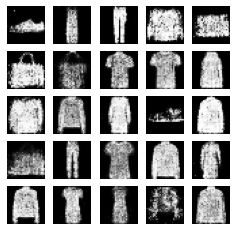

Time for epoch 30 is 3.5386343002319336 sec


In [ ]:
train(train_dataset, 200)